In [94]:
import requests
import pandas as pd
import platform
from isoweek import Week
print(platform.python_version())

3.9.4


In [313]:
# Source: https://www.ssb.no/statbank/table/07995/
# Vax data: https://www.fhi.no/sv/vaksine/koronavaksinasjonsprogrammet/koronavaksinasjonsstatistikk/
# Detailed vax data for 65+: https://statistikk.fhi.no/sysvak/antall-vaksinerte?etter=diagnose&fordeltPaa=dag&diagnose=COVID_19&alder=9,10,11&dose=01,02,03&fraDato=2020-12-27&tilDato=2022-02-05
POST_URL = "https://data.ssb.no/api/v0/en/table/07995"
payload = {
  "query": [
    {
      "code": "Kjonn",
      "selection": {
        "filter": "item",
        "values": [
          "0"
        ]
      }
    },
    {
      "code": "Alder",
      "selection": {
        "filter": "item",
        "values": [
          "999A",
          "000",
          "001",
          "002",
          "003",
          "004",
          "005",
          "006",
          "007",
          "008",
          "009",
          "010",
          "011",
          "012",
          "013",
          "014",
          "015",
          "016",
          "017",
          "018",
          "019",
          "020",
          "021",
          "022",
          "023",
          "024",
          "025",
          "026",
          "027",
          "028",
          "029",
          "030",
          "031",
          "032",
          "033",
          "034",
          "035",
          "036",
          "037",
          "038",
          "039",
          "040",
          "041",
          "042",
          "043",
          "044",
          "045",
          "046",
          "047",
          "048",
          "049",
          "050",
          "051",
          "052",
          "053",
          "054",
          "055",
          "056",
          "057",
          "058",
          "059",
          "060",
          "061",
          "062",
          "063",
          "064",
          "065",
          "066",
          "067",
          "068",
          "069",
          "070",
          "071",
          "072",
          "073",
          "074",
          "075",
          "076",
          "077",
          "078",
          "079",
          "080",
          "081",
          "082",
          "083",
          "084",
          "085",
          "086",
          "087",
          "088",
          "089",
          "090",
          "091",
          "092",
          "093",
          "094",
          "095",
          "096",
          "097",
          "098",
          "099",
          "100",
          "101",
          "102",
          "103",
          "104",
          "105+"
        ]
      }
    },
    {
      "code": "Tid",
      "selection": {
        "filter": "item",
        "values": [
          "2012",
          "2013",
          "2014",
          "2015",
          "2016",
          "2017",
          "2018",
          "2019",
          "2020",
          "2021",
        ]
      }
    }
  ],
  "response": {
    "format": "json-stat2"
  }
}

In [317]:
# Post spørring og få Pandas dataframe i retur
# benytter biblioteket pyjstat for JSON-stat

from pyjstat import pyjstat
import requests

resultat = requests.post(POST_URL, json = payload)
# Resultat gir bare http statuskode - 200 hvis OK. Body ligger i resultat.text
print(resultat)

dataset = pyjstat.Dataset.read(resultat.text)
raw = dataset.write('dataframe')
raw.head()

<Response [200]>


,sex,age,week,contents,year,value
0,Both sexes,All ages,Week 1,Deaths,2012,895.0
1,Both sexes,All ages,Week 1,Deaths,2013,1004.0
2,Both sexes,All ages,Week 1,Deaths,2014,781.0
3,Both sexes,All ages,Week 1,Deaths,2015,937.0
4,Both sexes,All ages,Week 1,Deaths,2016,870.0


In [487]:
# Process death data
df = raw.copy()
df["week_str"] = df.week.str.extract(r'(\d+)')
df["week_str"] = df["week_str"].apply(lambda x: "-W" + x.zfill(2) + "-1")
df['date'] = df[['year', 'week_str']].agg(''.join, axis=1)
df['date'] = pd.to_datetime(df['date'], format="%Y-W%U-%w")
df.age = df.age.str.extract(r"(\d+)").replace(np.nan,-1).astype(int)
df.index = df.date
df = df[~df.isna()]

In [495]:
# Groupby age brackets "0-21","21-42","43-64", "65+"
# pd.cut: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.cut.html
grouped = df.groupby([pd.cut(df["age"], np.array([0,21,42,64,106]), labels=["0-21","21-42","43-64", "65+"]), df.index]).sum()
grouped = grouped.unstack(level=0)["value"]
grouped = grouped[(grouped != 0.)["65+"]]
grouped.columns

CategoricalIndex(['0-21', '21-42', '43-64', '65+'], categories=['0-21', '21-42', '43-64', '65+'], ordered=True, name='age', dtype='category')

Text(0.5, 1.0, 'Age-stratified deaths, Norway, 2012-2022')

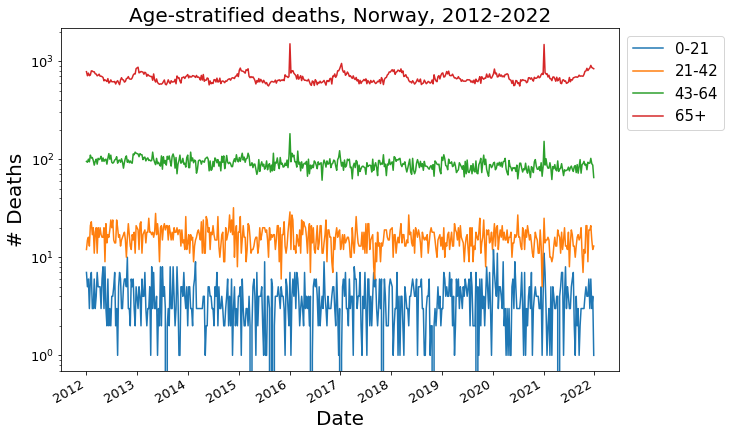

In [507]:
# Plot deaths for age brackets. Note the clear cyclical (annual) trend only present in the oldest age group
import matplotlib.pylab as plt
grouped.plot(figsize=(10,7), logy=True)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xlabel("Date")
plt.ylabel("# Deaths")
plt.title("Age-stratified deaths, Norway, 2012-2022")

In [496]:
pre_2020_median = grouped["65+"][:"2019"].groupby(grouped["65+"][:"2019"].index.strftime("%W").astype(int)).median()
pre_2020_sd = grouped["65+"][:"2019"].groupby(grouped["65+"][:"2019"].index.strftime("%W").astype(int)).std()

In [497]:
pre_2020_median.name = "65+_median"
pre_2020_sd.name = "65+_std"
pre_2020 = pd.concat([pre_2020_median, pre_2020_sd], axis=1)
pre_2020.head()

,65+_median,65+_std
date,,
1,808.0,276.044682
2,757.0,88.176669
3,775.0,46.358078
4,776.5,45.613086
5,765.5,32.359311


In [498]:
week_df = pd.DataFrame(index=grouped.index, data = {"week": grouped.index.strftime("%W").astype(int)})
age_deaths = grouped.merge(week_df, left_index=True, right_index=True)
age_deaths = age_deaths.merge(pre_2020, left_on="week", right_index=True)
age_deaths.sort_index(inplace=True)
age_deaths.head()

,0-21,21-42,43-64,65+,week,65+_median,65+_std
date,,,,,,,
2012-01-02,7.0,12.0,95.0,780.0,1,808.0,276.044682
2012-01-09,5.0,15.0,93.0,709.0,2,757.0,88.176669
2012-01-16,6.0,16.0,100.0,754.0,3,775.0,46.358078
2012-01-23,3.0,13.0,94.0,710.0,4,776.5,45.613086
2012-01-30,6.0,21.0,110.0,721.0,5,765.5,32.359311


In [500]:
age_deaths["65+_centered"] =  age_deaths["65+"] - age_deaths["65+_median"]
age_deaths.head()

,0-21,21-42,43-64,65+,week,65+_median,65+_std,65+_centered
date,,,,,,,,
2012-01-02,7.0,12.0,95.0,780.0,1,808.0,276.044682,-28.0
2012-01-09,5.0,15.0,93.0,709.0,2,757.0,88.176669,-48.0
2012-01-16,6.0,16.0,100.0,754.0,3,775.0,46.358078,-21.0
2012-01-23,3.0,13.0,94.0,710.0,4,776.5,45.613086,-66.5
2012-01-30,6.0,21.0,110.0,721.0,5,765.5,32.359311,-44.5


Text(0.5, 0, 'Date')

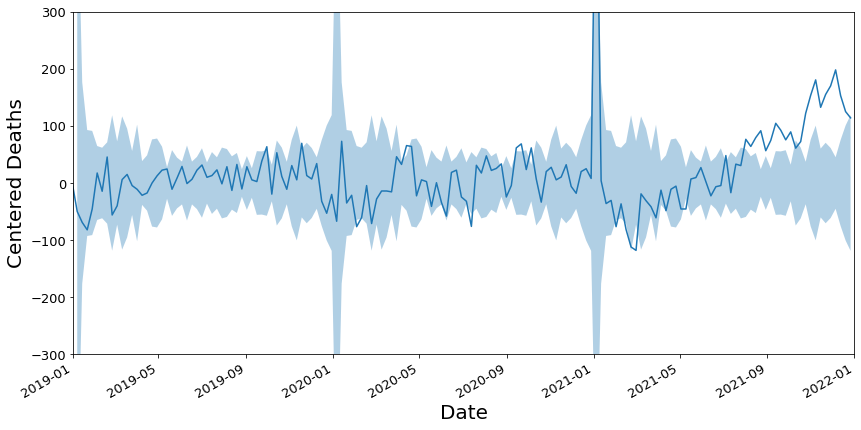

In [509]:


plt.rc('font', size=10) #controls default text size
plt.rc('axes', titlesize=20) #fontsize of the title
plt.rc('axes', labelsize=20) #fontsize of the x and y labels
plt.rc('xtick', labelsize=13) #fontsize of the x tick labels
plt.rc('ytick', labelsize=13) #fontsize of the y tick labels
plt.rc('legend', fontsize=15) #fontsize of the legend

ax = age_deaths["65+_centered"].plot(figsize=(14,7))
ax.fill_between(age_deaths.index, - 2 * age_deaths["65+_std"], 2 * age_deaths["65+_std"], alpha=0.35)
plt.ylim([-300,300])
plt.xlim(["2019", "2022"])
plt.ylabel("Centered Deaths")
plt.xlabel("Date")

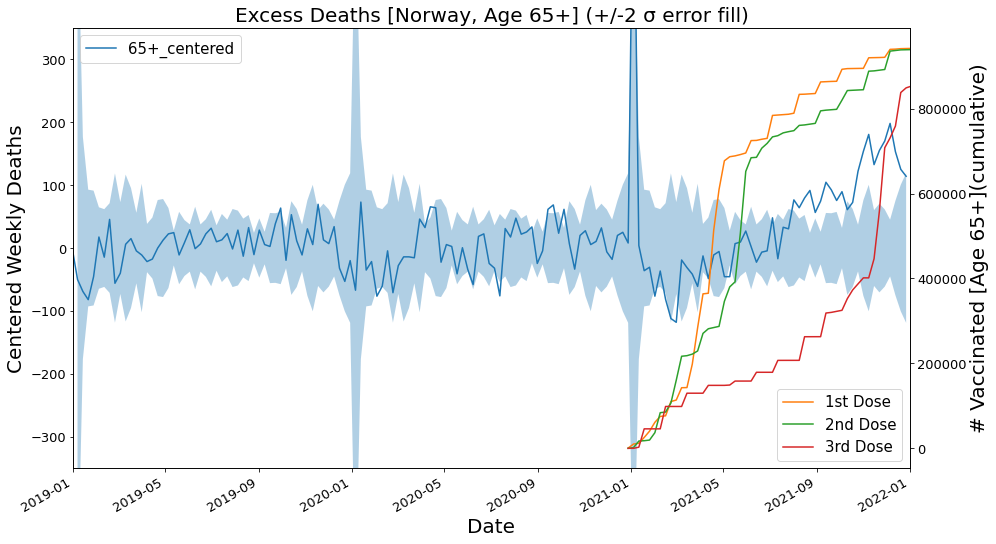

In [510]:
# Add vaccination data for this age group
raw2 = pd.read_csv("../data/2022-02-07.antall-vaksinasjoner-etter-sykdom-fordelt-på-dag-27.12.2020-05.02.2022.csv", delimiter=";", skiprows=1)
raw2.head()

raw2.index = pd.to_datetime(raw2.iloc[:, 0])
vax2 = pd.concat([raw2.iloc[:, 1:4].sum(axis=1), raw2.iloc[:, 4:7].sum(axis=1), raw2.iloc[:, 7:10].sum(axis=1)], axis=1)
vax2.columns = ["1st Dose", "2nd Dose", "3rd Dose"]

week_vax2 = vax2.groupby(pd.Grouper(freq="W-MON")).sum()

# Plot deaths among 64+ category with respect to deaths
death_vax = age_deaths.merge(week_vax2, left_index=True, right_index=True, how="outer")
ax = death_vax["65+_centered"].plot(figsize=(15,9))
ax.fill_between(death_vax.index, - 2 * death_vax["65+_std"], 2 * death_vax["65+_std"], alpha=0.35)
plt.ylim([-350,350])
plt.xlim(["2019", "2022"])
plt.ylabel("Centered Weekly Deaths")
plt.xlabel("Date")
death_vax.loc[:, ["1st Dose"]].cumsum().plot(ax=ax, secondary_y=True, legend=False)
death_vax.loc[:, ["2nd Dose"]].cumsum().plot(ax=ax, secondary_y=True, legend=False)
death_vax.loc[:, ["3rd Dose"]].cumsum().plot(ax=ax, secondary_y=True, legend=False)
first_legend = plt.legend(handles=[ax.lines[0]], loc='upper left')
plt.gca().add_artist(first_legend)
plt.legend(handles=ax.right_ax.lines, loc='lower right')
plt.title("Excess Deaths [Norway, Age 65+] (+/-2 σ error fill)")
ax.right_ax.set_ylabel("# Vaccinated [Age 65+](cumulative)")
plt.savefig("../figures/norway_deaths_vax.pdf")